# Image Alignment / Registration
Used in building panoramic, HDR photos and in the medical fields to look at different scans and find small changes


## Align an image to a template.

## Theory

1. A **Homography** transforms a square to arbitrary quad. 

### Translation does not involve any rotation, euclidean transformations handle rotation but the dimesions of the original image are not changed. Affine involves some dimension changes and homography is the most general form of image transformation to any arbitrary quad.



## Theory
2. Images of two planes are related by a **Homography**
3. We need **4 corresponding points** to estimate Homography

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


## Step 1: Read Tempalate and Scanned Image

In [5]:
# Read reference image
print("Reading reference image : ", "form.jpg")
im1 = cv2.imread("form.jpg", 1)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

# Read image to be aligned
print("Reading image to align : ", "scanned-form.jpg")
im2 = cv2.imread("scanned-form.jpg", 1)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

Reading reference image :  form.jpg
Reading image to align :  scanned-form.jpg


Text(0.5, 1.0, 'Scanned Form')

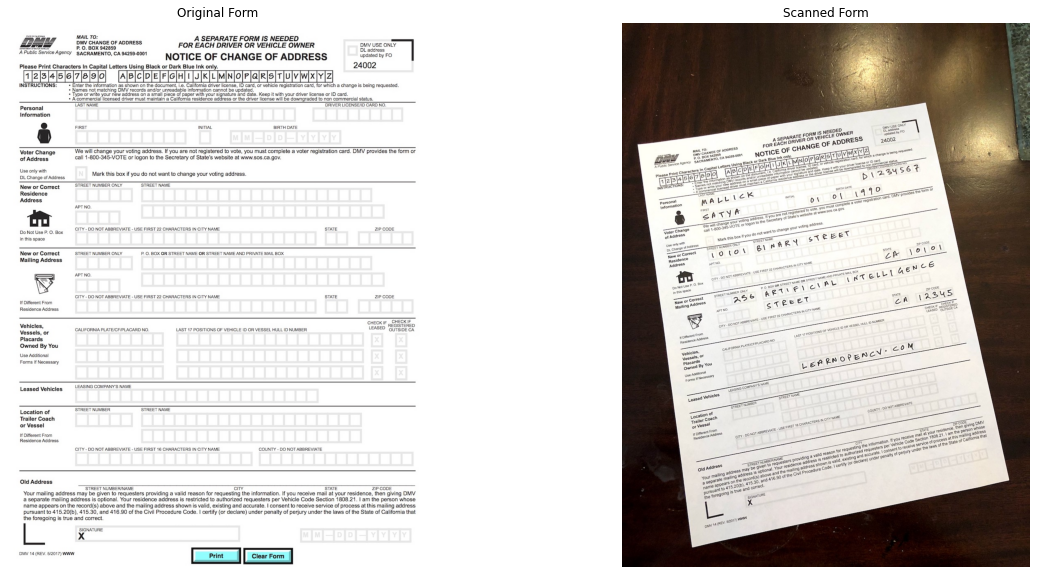

In [8]:
plt.figure(figsize=[20,10]); 
plt.subplot(121); plt.axis('off'); plt.imshow(im1); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(im2); plt.title("Scanned Form")

## Step 2: Find keypoints in both Images

Think of keypoints as corner points that are stable under image transformations

In [11]:
# Convert images to grayscale as the functions for detecting orb features require grayscale images.
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
  

# Detect ORB features and compute descriptors.
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)

# Essentially the descroiptors help us match the same keypoints in different images.


# Display 
im1_display = cv2.drawKeypoints(im1, keypoints1, outImage=np.array([]), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im2_display = cv2.drawKeypoints(im2, keypoints2, outImage=np.array([]), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


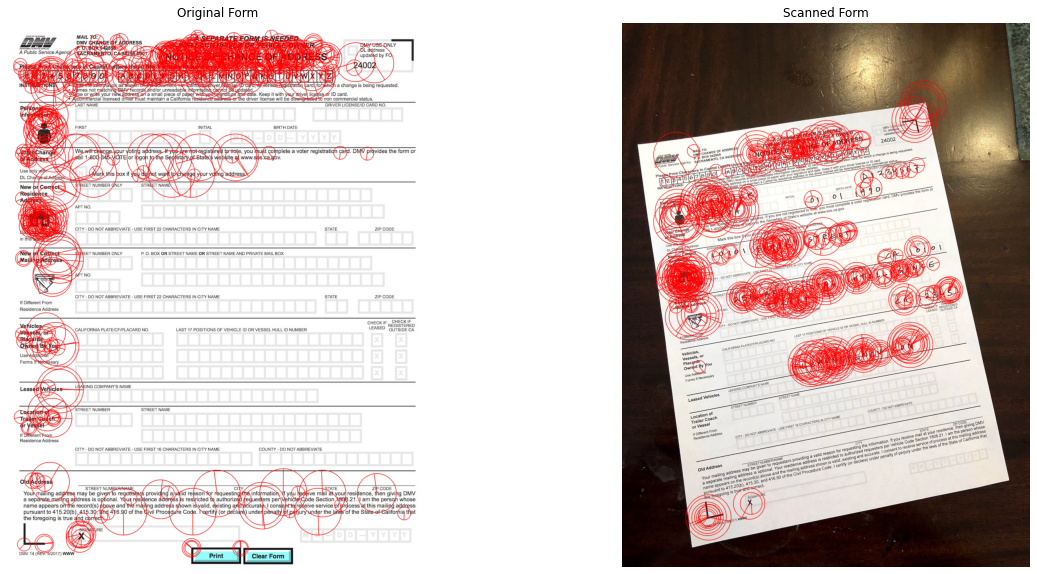

In [12]:
plt.figure(figsize=[20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(im1_display); plt.title("Original Form");
plt.subplot(122); plt.axis('off'); plt.imshow(im2_display); plt.title("Scanned Form");

## the centre of the circle represents the location of the keypoint, the radius of the circle represents the scale of the keypoint and the line connecting the centre to the circumference represents the orientation of the keypoint.


The keypoints in both the images are different but we want to find the keypoints that both the images have so we can define the homography for the image.



## Step 3 : Match keypoints in the two image

In [14]:
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(descriptors1, descriptors2, None)
  
# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]


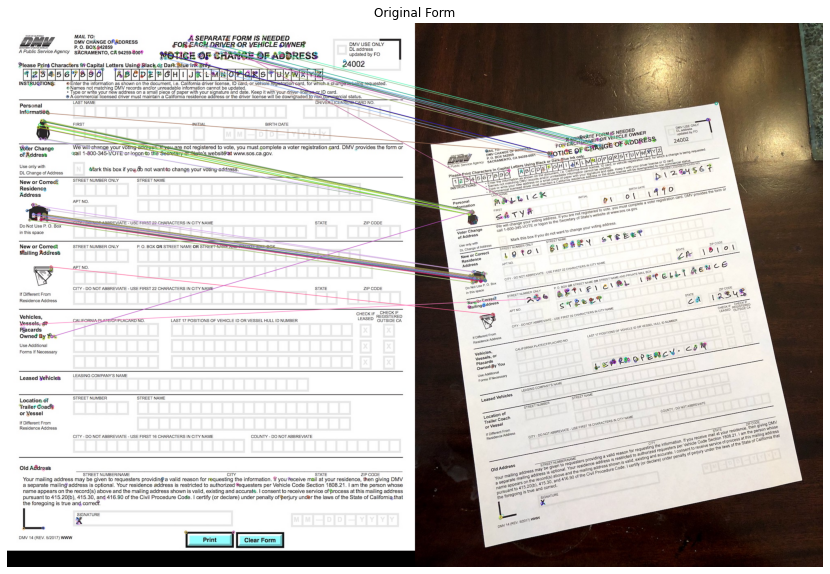

In [15]:
# Draw top matches
im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

plt.figure(figsize=[40,10])
plt.imshow(im_matches); plt.axis('off'); plt.title("Original Form");


## Step 4: Find Homography

In [16]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
  points1[i, :] = keypoints1[match.queryIdx].pt
  points2[i, :] = keypoints2[match.trainIdx].pt
  
# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

## Step 5: Warp image

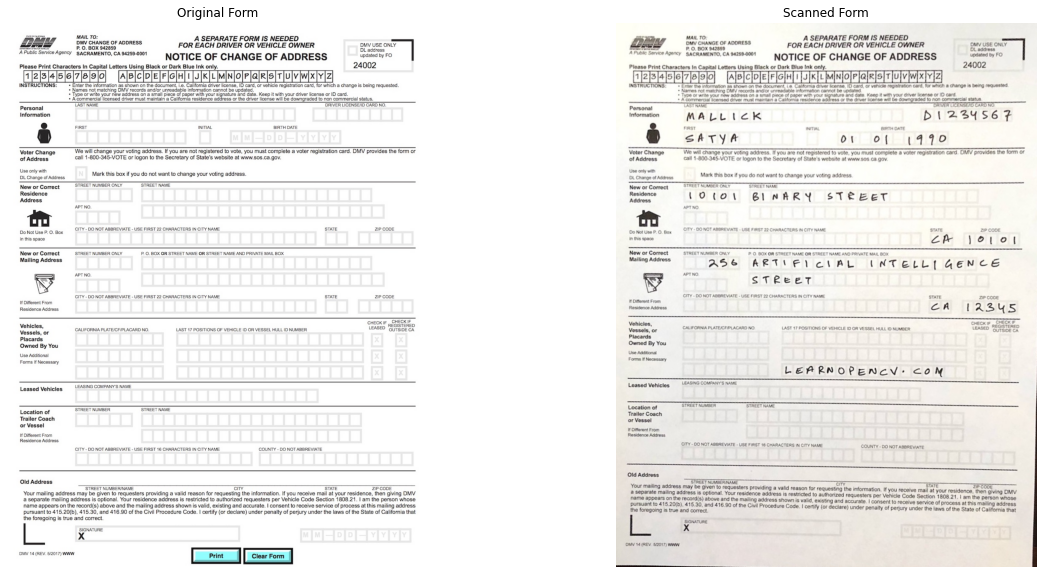

In [17]:
# Use homography to warp image
height, width, channels = im1.shape
im2_reg = cv2.warpPerspective(im2, h, (width, height))
# Display results 
plt.figure(figsize=[20,10]); 
plt.subplot(121); plt.imshow(im1); plt.axis('off'); plt.title("Original Form");
plt.subplot(122); plt.imshow(im2_reg); plt.axis('off'); plt.title("Scanned Form");